# 🌎 CSE151B Spring 2025 Climate Emulation Competition

### 📦 Required Libraries
We install the necessary Python packages for data loading, deep learning, and visualization.


In [1]:
!pip install xarray zarr dask lightning matplotlib wandb cftime einops --quiet

import os
from datetime import datetime
import numpy as np
import xarray as xr
import dask.array as da
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import lightning.pytorch as pl


### ⚙️ Configuration Setup  
Defining all model, data, and training hyperparameters in one place for easy control and reproducibility.

### 📊 Data Configuration

We define the dataset settings used for training and evaluation. This includes:

- **`path`**: Path to the `.zarr` dataset containing monthly climate variables from CMIP6 simulations.
- **`input_vars`**: Climate forcing variables (e.g., CO₂, CH₄) used as model inputs.
- **`output_vars`**: Target variables to predict — surface air temperature (`tas`) and precipitation (`pr`).
- **`target_member_id`**: Ensemble member to use from the simulations (each SSP has 3) for target variables.
- **`train_ssps`**: SSP scenarios used for training (low to high emissions).
- **`test_ssp`**: Scenario held out for evaluation (Must be set to SSP245).
- **`test_months`**: Number of months to include in the test split (Must be set to 120).
- **`batch_size`** and **`num_workers`**: Data loading parameters for PyTorch training.

These settings reflect how the challenge is structured: models must learn from some emission scenarios and generalize to unseen ones.

> - `test_ssp` must remain **`ssp245`**, which is the held-out evaluation scenario.
> - `test_months` must be **`120`**, corresponding to the last 10 years (monthly resolution) of the scenario.



In [ ]:
config = {
    "data": {
        "path": "processed_data_cse151b_v2_corrupted_ssp245/processed_data_cse151b_v2_corrupted_ssp245.zarr",
        "input_vars": ["CO2", "SO2", "CH4", "BC", "rsdt"],
        "output_vars": ["tas", "pr"],
        "target_member_id": 0,
        "train_ssps": ["ssp126", "ssp370", "ssp585"],
        "test_ssp": "ssp245",
        "test_months": 120,
        "batch_size": 16,
        "num_workers": 4,
    },
    "model": {
        "type": "simple_cnn",
        "kernel_size": 3,
        "init_dim": 64,
        "depth": 4,
        "dropout_rate": 0.1,
    },
    "training": {
        "lr": 1e-3,
    },
    "trainer": {
        "max_epochs": 40,
        "accelerator": "auto",
        "devices": "auto",
        "precision": 16,
        # "amp_backend": "native",
        "deterministic": True,
        "num_sanity_val_steps": 0,
    },
    "seed": 42,
}
pl.seed_everything(config["seed"])  # Set seed for reproducibility

Seed set to 42


42

### 🔧 Spatial Weighting Utility Function

This cell sets up utility functions for reproducibility and spatial weighting:

- **`get_lat_weights(latitude_values)`**: Computes cosine-based area weights for each latitude, accounting for the Earth's curvature. This is critical for evaluating global climate metrics fairly — grid cells near the equator represent larger surface areas than those near the poles.


In [3]:
def get_lat_weights(latitude_values):
    lat_rad = np.deg2rad(latitude_values)
    weights = np.cos(lat_rad)
    return weights / np.mean(weights)

### 🧠 Pure U-Net: Capturing Multi-Scale Spatial Features

This model is a classic **U-Net architecture**, chosen for its ability to learn **hierarchical spatial features** and reconstruct detailed outputs by combining information across different scales. It's particularly well-suited for image-to-image prediction tasks like climate emulation.

* The architecture consists of a symmetric **encoder-decoder structure** with **skip connections**.
* The **encoder** repeatedly applies convolutional layers and downsampling (max-pooling) to extract progressively more abstract and coarser spatial features.
* The **decoder** upsamples these features, using corresponding skip connections from the encoder to reintegrate fine-grained details, leading to the final high-resolution predictions.


In [4]:
import torch.nn.functional as F

class UNetEncoder(nn.Module):
    def __init__(self, in_channels, base_channels=32, mid_channels=64, bottle_channels=128): # Added mid_channels
        super().__init__()
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels, base_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_channels), nn.ReLU(inplace=True),
            nn.Conv2d(base_channels, base_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_channels), nn.ReLU(inplace=True),
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc2 = nn.Sequential(
            nn.Conv2d(base_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels), nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels), nn.ReLU(inplace=True),
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc3 = nn.Sequential(
            nn.Conv2d(mid_channels, bottle_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(bottle_channels), nn.ReLU(inplace=True),
            nn.Conv2d(bottle_channels, bottle_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(bottle_channels), nn.ReLU(inplace=True),
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)


    def forward(self, x):
        f1 = self.enc1(x)
        p1 = self.pool1(f1)

        f2 = self.enc2(p1)
        p2 = self.pool2(f2)

        f3 = self.enc3(p2)
        b = self.pool3(f3)

        return [f1, f2, f3], b


class UNetDecoder(nn.Module):
    def __init__(self, base_channels=32, mid_channels=64, bottle_channels=128, out_channels=2):
        super().__init__()

        self.up1 = nn.ConvTranspose2d(bottle_channels, bottle_channels, kernel_size=2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(bottle_channels + bottle_channels, bottle_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(bottle_channels), nn.ReLU(inplace=True),
            nn.Conv2d(bottle_channels, bottle_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(bottle_channels), nn.ReLU(inplace=True),
        )

        self.up2 = nn.ConvTranspose2d(bottle_channels, mid_channels, kernel_size=2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(mid_channels + mid_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels), nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels), nn.ReLU(inplace=True),
        )

        self.up3 = nn.ConvTranspose2d(mid_channels, base_channels, kernel_size=2, stride=2)
        self.dec3 = nn.Sequential(
            nn.Conv2d(base_channels + base_channels, base_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_channels), nn.ReLU(inplace=True),
            nn.Conv2d(base_channels, base_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_channels), nn.ReLU(inplace=True),
        )

        self.final_conv = nn.Conv2d(base_channels, out_channels, kernel_size=1)

    def forward(self, b, skips):
        f1, f2, f3 = skips

        u1 = self.up1(b)
        c1 = torch.cat([u1, f3], dim=1)
        d1 = self.dec1(c1)

        u2 = self.up2(d1)
        c2 = torch.cat([u2, f2], dim=1)
        d2 = self.dec2(c2)

        u3 = self.up3(d2)
        c3 = torch.cat([u3, f1], dim=1)
        d3 = self.dec3(c3)

        y_hat = self.final_conv(d3)
        return y_hat

### 🧠 Pure Fourier Neural Operator (FNO): Learning Global Spectral Dynamics

This model implements a **Fourier Neural Operator (FNO)**, a novel architecture designed to learn mappings between infinite-dimensional function spaces. It's especially effective for physical systems governed by partial differential equations, making it powerful for modeling global climate dynamics.

* The model starts by **lifting** the input features into a higher-dimensional space.
* Its core involves a series of **spectral convolution layers** that operate directly in the Fourier (frequency) domain, allowing it to efficiently capture global, long-range dependencies.
* These spectral operations are combined with local, **pointwise convolutions** and non-linear activations.
* Finally, the features are **projected back down** to the desired output channels.

In [5]:
from torch.amp import autocast

In [6]:
import torch.fft

class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes):
        super().__init__()
        self.in_ch  = in_channels
        self.out_ch = out_channels
        self.modes  = modes

        self.scale   = 1 / (in_channels * out_channels)
        self.weights = nn.Parameter(
            self.scale * torch.randn(in_channels, out_channels, modes, modes, 2)
        )

    def compl_mul2d(self, input, weights):
        real = input.real
        imag = input.imag

        w_real = weights[..., 0]
        w_imag = weights[..., 1]

        out_real = torch.einsum("bcij,coij->boij", real, w_real) \
                 - torch.einsum("bcij,coij->boij", imag, w_imag)

        out_imag = torch.einsum("bcij,coij->boij", real, w_imag) \
                 + torch.einsum("bcij,coij->boij", imag, w_real)

        return torch.complex(out_real, out_imag)

    def forward(self, x):
        B, C, H, W = x.shape
        device = x.device

        with autocast("cuda", enabled=False):
            x_fp32 = x.float()
            x_ft   = torch.fft.rfft2(x_fp32, norm="ortho")

        H_ft   = x_ft.size(-2)
        W_ft   = x_ft.size(-1)
        m1     = min(self.modes, H_ft, W_ft)

        x_slice = x_ft[:, :, :m1, :m1]      

        w_slice = self.weights[..., :m1, :m1, :]  

        out_ft = torch.zeros(
            B, self.out_ch, H_ft, W_ft,
            dtype=torch.cfloat, device=device
        )
        out_ft[:, :, :m1, :m1] = self.compl_mul2d(x_slice, w_slice)

        with autocast("cuda", enabled=False):
            x_rec = torch.fft.irfft2(out_ft, s=(H, W), norm="ortho")

        return x_rec.to(x.dtype)


class FNO2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes=16, width=64):
        super().__init__()
        self.modes = modes
        self.width = width

        self.fc0 = nn.Linear(in_channels, width)

        self.spectral_layers = nn.ModuleList([
            SpectralConv2d(width, width, modes) for _ in range(8)
        ])
        self.pointwise_convs = nn.ModuleList([
            nn.Conv2d(width, width, kernel_size=1) for _ in range(8)
        ])

        self.fc1 = nn.Linear(width, 128)
        self.fc2 = nn.Linear(128, out_channels)

    def forward(self, x):
        B, C, H, W = x.shape

        x = x.permute(0, 2, 3, 1).reshape(B * H * W, C)
        x = self.fc0(x)
        x = x.view(B, H, W, self.width).permute(0, 3, 1, 2)

        for spec, pw in zip(self.spectral_layers, self.pointwise_convs):
            x1 = spec(x)
            x2 = pw(x)
            x  = x + x1 + x2
            x  = nn.GELU()(x)
            x  = nn.Dropout2d(0.3)(x)

        x = x.permute(0, 2, 3, 1).reshape(B * H * W, self.width)
        x = nn.GELU()(self.fc1(x))
        x = self.fc2(x)
        x = x.view(B, H, W, -1).permute(0, 3, 1, 2)

        return x

### 📐 Normalizer: Z-Score Scaling for Climate Inputs & Outputs

This class handles **Z-score normalization**, a crucial preprocessing step for stable and efficient neural network training:

- **`set_input_statistics(mean, std)` / `set_output_statistics(...)`**: Store the mean and standard deviation computed from the training data for later use.
- **`normalize(data, data_type)`**: Standardizes the data using `(x - mean) / std`. This is applied separately to inputs and outputs.
- **`inverse_transform_output(data)`**: Converts model predictions back to the original physical units (e.g., Kelvin for temperature, mm/day for precipitation).

Normalizing the data ensures the model sees inputs with similar dynamic ranges and avoids biases caused by different variable scales.


In [7]:
class Normalizer:
    def __init__(self):
        self.mean_in, self.std_in = None, None
        self.mean_out, self.std_out = None, None

    def set_input_statistics(self, mean, std):
        self.mean_in = mean
        self.std_in = std

    def set_output_statistics(self, mean, std):
        self.mean_out = mean
        self.std_out = std

    def normalize(self, data, data_type):
        if data_type == "input":
            return (data - self.mean_in) / self.std_in
        elif data_type == "output":
            return (data - self.mean_out) / self.std_out

    def inverse_transform_output(self, data):
        return data * self.std_out + self.mean_out


### 🌍 Data Module: Loading, Normalization, and Splitting

This section handles the entire data pipeline.

#### `ClimateDataset`
- A simple PyTorch `Dataset` wrapper that preloads the entire (normalized) dataset into memory using Dask.
- Converts the data to PyTorch tensors and handles any `NaN` checks up front.

#### `ClimateDataModule`
A PyTorch Lightning `DataModule` that handles:
- ✅ **Loading data** from different SSP scenarios and ensemble members
- ✅ **Broadcasting non-spatial inputs** (like CO₂) to match spatial grid size
- ✅ **Normalization** using mean/std computed from training data only
- ✅ **Splitting** into training, validation, and test sets:
  - Training: All months from selected SSPs (except last 10 years of SSP370)
  - Validation: Last 10 years (120 months) of SSP370
  - Test: Last 10 years of SSP245 (unseen scenario)
- ✅ **Batching** and parallelized data loading via PyTorch `DataLoader`s
- ✅ **Latitude-based area weighting** for fair climate metric evaluation
- Shape of the inputs are Batch_Size X 5 (num_input_variables) X 48 X 72
- Shape of ouputputs are Batch_Size X 2 (num_output_variables) X 48 X 72


In [8]:
class ClimateDataset(Dataset):
    def __init__(self, inputs_dask, outputs_dask, output_is_normalized=True):
        self.size = inputs_dask.shape[0]
        print(f"Creating dataset with {self.size} samples...")

        inputs_np = inputs_dask.compute()
        outputs_np = outputs_dask.compute()

        self.inputs = torch.from_numpy(inputs_np).float()
        self.outputs = torch.from_numpy(outputs_np).float()

        if torch.isnan(self.inputs).any() or torch.isnan(self.outputs).any():
            raise ValueError("NaNs found in dataset")

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        return self.inputs[idx], self.outputs[idx]


class ClimateDataModule(pl.LightningDataModule):
    def __init__(
        self,
        path,
        input_vars,
        output_vars,
        train_ssps,
        test_ssp,
        target_member_id,
        val_split=0.1,
        test_months=120,
        batch_size=32,
        num_workers=0,
        seed=42,
    ):
        super().__init__()
        self.path = path
        self.input_vars = input_vars
        self.output_vars = output_vars
        self.train_ssps = train_ssps
        self.test_ssp = test_ssp
        self.target_member_id = target_member_id
        self.val_split = val_split
        self.test_months = test_months
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.seed = seed
        self.normalizer = Normalizer()

    def prepare_data(self):
        assert os.path.exists(self.path), f"Data path not found: {self.path}"

    def setup(self, stage=None):
        ds = xr.open_zarr(self.path, consolidated=False, chunks={"time": 24})
        spatial_template = ds["rsdt"].isel(time=0, ssp=0, drop=True)

        def load_ssp(ssp):
            input_dask, output_dask = [], []
            for var in self.input_vars:
                da_var = ds[var].sel(ssp=ssp)
                if "latitude" in da_var.dims:
                    da_var = da_var.rename({"latitude": "y", "longitude": "x"})
                if "member_id" in da_var.dims:
                    da_var = da_var.sel(member_id=self.target_member_id)
                if set(da_var.dims) == {"time"}:
                    da_var = da_var.broadcast_like(spatial_template).transpose("time", "y", "x")
                input_dask.append(da_var.data)

            for var in self.output_vars:
                da_out = ds[var].sel(ssp=ssp, member_id=self.target_member_id)
                if "latitude" in da_out.dims:
                    da_out = da_out.rename({"latitude": "y", "longitude": "x"})
                output_dask.append(da_out.data)

            return da.stack(input_dask, axis=1), da.stack(output_dask, axis=1)

        train_input, train_output, val_input, val_output = [], [], None, None

        for ssp in self.train_ssps:
            x, y = load_ssp(ssp)
            if ssp == "ssp370":
                val_input = x[-self.test_months:]
                val_output = y[-self.test_months:]
                train_input.append(x[:-self.test_months])
                train_output.append(y[:-self.test_months])
            else:
                train_input.append(x)
                train_output.append(y)

        train_input = da.concatenate(train_input, axis=0)
        train_output = da.concatenate(train_output, axis=0)

        self.normalizer.set_input_statistics(
            mean=da.nanmean(train_input, axis=(0, 2, 3), keepdims=True).compute(),
            std=da.nanstd(train_input, axis=(0, 2, 3), keepdims=True).compute(),
        )
        self.normalizer.set_output_statistics(
            mean=da.nanmean(train_output, axis=(0, 2, 3), keepdims=True).compute(),
            std=da.nanstd(train_output, axis=(0, 2, 3), keepdims=True).compute(),
        )

        train_input_norm = self.normalizer.normalize(train_input, "input")
        train_output_norm = self.normalizer.normalize(train_output, "output")
        val_input_norm = self.normalizer.normalize(val_input, "input")
        val_output_norm = self.normalizer.normalize(val_output, "output")

        test_input, test_output = load_ssp(self.test_ssp)
        test_input = test_input[-self.test_months:]
        test_output = test_output[-self.test_months:]
        test_input_norm = self.normalizer.normalize(test_input, "input")

        self.train_dataset = ClimateDataset(train_input_norm, train_output_norm)
        self.val_dataset = ClimateDataset(val_input_norm, val_output_norm)
        self.test_dataset = ClimateDataset(test_input_norm, test_output, output_is_normalized=False)

        self.lat = spatial_template.y.values
        self.lon = spatial_template.x.values
        self.area_weights = xr.DataArray(get_lat_weights(self.lat), dims=["y"], coords={"y": self.lat})

        print("mean_out:", self.normalizer.mean_out.flatten())
        print("std_out:",  self.normalizer.std_out.flatten())
    
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True,
                          num_workers=self.num_workers, pin_memory=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False,
                          num_workers=self.num_workers, pin_memory=True)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False,
                          num_workers=self.num_workers, pin_memory=True)

    def get_lat_weights(self):
        return self.area_weights

    def get_coords(self):
        return self.lat, self.lon

### ⚡ ClimateEmulationModule: Lightning Wrapper for Climate Model Emulation

This is the core model wrapper built with **PyTorch Lightning**, which organizes the training, validation, and testing logic for the climate emulation task. Lightning abstracts away much of the boilerplate code in PyTorch-based deep learning workflows, making it easier to scale models.

#### ✅ Key Features

- **`training_step` / `validation_step` / `test_step`**: Standard Lightning hooks for computing loss and predictions at each stage. The loss used is **Mean Squared Error (MSE)**.

- **Normalization-aware outputs**:
  - During validation and testing, predictions and targets are denormalized before evaluation using stored mean/std statistics.
  - This ensures evaluation is done in real-world units (Kelvin and mm/day).

- **Metric Evaluation** via `_evaluate()`:
  For each variable (`tas`, `pr`), it calculates:
  - **Monthly Area-Weighted RMSE**
  - **Time-Mean RMSE** (RMSE on 10-year average's)
  - **Time-Stddev MAE** (MAE on 10-year standard deviation; a measure of temporal variability)
    
  These metrics reflect the competition's evaluation criteria and are logged and printed.

In [9]:
import pandas as pd

class ClimateEmulationModule(pl.LightningModule):
    def __init__(self, model, learning_rate=1e-4):
        super().__init__()
        self.model = model
        self.save_hyperparameters(ignore=['model']) # Save all hyperparameters except the model to self.hparams.<param_name>
        self.criterion = nn.MSELoss()
        self.normalizer = None
        self.val_preds, self.val_targets = [], []
        self.test_preds, self.test_targets = [], []

    def forward(self, x):
        return self.model(x)

    def on_fit_start(self):
        self.normalizer = self.trainer.datamodule.normalizer  # Get the normalizer from the datamodule (see above)

    def training_step(self, batch, batch_idx):
        x, y = batch # Unpack inputs and targets (this is the output of the _getitem_ method in the Dataset above)
        y_hat = self(x)   # Forward pass
        loss = self.criterion(y_hat, y)  # Calculate loss
        self.log("train/loss", loss)  # Log loss for tracking
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("val/loss", loss)

        y_hat_np = self.normalizer.inverse_transform_output(y_hat.detach().cpu().numpy())
        y_np = self.normalizer.inverse_transform_output(y.detach().cpu().numpy())
        self.val_preds.append(y_hat_np)
        self.val_targets.append(y_np)

        return loss

    def on_validation_epoch_end(self):
        # Concatenate all predictions and ground truths from each val step/batch into one array
        preds = np.concatenate(self.val_preds, axis=0)
        trues = np.concatenate(self.val_targets, axis=0)
        self._evaluate(preds, trues, phase="val")
        np.save("val_preds.npy", preds)
        np.save("val_trues.npy", trues)
        self.val_preds.clear()
        self.val_targets.clear()

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        y_hat_np = self.normalizer.inverse_transform_output(y_hat.detach().cpu().numpy())
        y_np = y.detach().cpu().numpy()
        self.test_preds.append(y_hat_np)
        self.test_targets.append(y_np)
        print("y_hat_norm sample:", y_hat.detach().cpu().numpy().ravel()[:5])
        print("y_hat_raw sample:", y_hat_np.flatten()[:5])
        print("y_true_raw sample:", y_np.flatten()[:5])

    def on_test_epoch_end(self):
        # Concatenate all predictions and ground truths from each test step/batch into one array
        preds = np.concatenate(self.test_preds, axis=0)
        trues = np.concatenate(self.test_targets, axis=0)
        self._evaluate(preds, trues, phase="test")
        self._save_submission(preds)
        self.test_preds.clear()
        self.test_targets.clear()

    # def configure_optimizers(self):
    #     opt = torch.optim.AdamW(self.parameters(), lr=self.hparams.learning_rate, weight_decay=1e-4)
    #     sched = {
    #         "scheduler": torch.optim.lr_scheduler.OneCycleLR(
    #             opt,
    #             max_lr=self.hparams.learning_rate,
    #             total_steps=self.trainer.estimated_stepping_batches,
    #             pct_start=0.1,
    #             div_factor=10,
    #         ),
    #         "interval": "step",
    #     }
    #     return [opt], [sched]
    def configure_optimizers(self):
        opt = torch.optim.AdamW(self.parameters(), lr=5e-4, weight_decay=1e-4)
        sched = {
            'scheduler': torch.optim.lr_scheduler.OneCycleLR(
                opt,
                max_lr=7e-4,
                total_steps=self.trainer.estimated_stepping_batches,
                pct_start=0.1,
                div_factor=15
            ),
            'interval': 'step'
        }
        return [opt], [sched]


    def _evaluate(self, preds, trues, phase="val"):
        datamodule = self.trainer.datamodule
        area_weights = datamodule.get_lat_weights()
        lat, lon = datamodule.get_coords()
        time = np.arange(preds.shape[0])
        output_vars = datamodule.output_vars

        for i, var in enumerate(output_vars):
            p = preds[:, i]
            t = trues[:, i]
            p_xr = xr.DataArray(p, dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})
            t_xr = xr.DataArray(t, dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})

            # RMSE
            rmse = np.sqrt(((p_xr - t_xr) ** 2).weighted(area_weights).mean(("time", "y", "x")).item())
            # RMSE of time-mean
            mean_rmse = np.sqrt(((p_xr.mean("time") - t_xr.mean("time")) ** 2).weighted(area_weights).mean(("y", "x")).item())
            # MAE of time-stddev
            std_mae = np.abs(p_xr.std("time") - t_xr.std("time")).weighted(area_weights).mean(("y", "x")).item()

            print(f"[{phase.upper()}] {var}: RMSE={rmse:.4f}, Time-Mean RMSE={mean_rmse:.4f}, Time-Stddev MAE={std_mae:.4f}")
            self.log_dict({
                f"{phase}/{var}/rmse": rmse,
                f"{phase}/{var}/time_mean_rmse": mean_rmse,
                f"{phase}/{var}/time_std_mae": std_mae,
            })

    def _save_submission(self, predictions):
        datamodule = self.trainer.datamodule
        lat, lon = datamodule.get_coords()
        output_vars = datamodule.output_vars
        time = np.arange(predictions.shape[0])

        rows = []
        for t_idx, t in enumerate(time):
            for var_idx, var in enumerate(output_vars):
                for y_idx, y in enumerate(lat):
                    for x_idx, x in enumerate(lon):
                        row_id = f"t{t_idx:03d}_{var}_{y:.2f}_{x:.2f}"
                        pred = predictions[t_idx, var_idx, y_idx, x_idx]
                        rows.append({"ID": row_id, "Prediction": pred})

        df = pd.DataFrame(rows)
        os.makedirs("submissions", exist_ok=True)
        filepath = f"submissions/kaggle_submission_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
        df.to_csv(filepath, index=False)
        print(f"✅ Submission saved to: {filepath}")

### 🧠 Hybrid U-Net + FNO: Synergizing Local and Global Understanding

This is our most advanced model, combining the strengths of the U-Net and the Fourier Neural Operator (FNO) into a powerful **hybrid architecture**. It aims to achieve superior performance by concurrently handling both local, multi-scale spatial details and global, long-range dynamic interactions in climate data.

* The model begins with a **U-Net encoder** that processes the input, extracting hierarchical spatial features and downsampling the data into a compact bottleneck representation.
* Crucially, a **Fourier Neural Operator (FNO) block** is integrated directly within this bottleneck. The FNO operates on the most compressed features to learn robust global relationships in the frequency domain.
* The processed features then flow into a **U-Net decoder**, which upsamples the information back to the original resolution, leveraging **skip connections** from the encoder to recover fine-grained spatial details.

In [10]:
class Hybrid_UNet_FNO(nn.Module):

    def __init__(self,
                 in_channels=5,
                 out_channels=2,
                 base_channels=32,
                 mid_channels=64,
                 bottle_channels=128,
                 fno_modes=32,
                 fno_width=128):

        super().__init__()

        self.encoder = UNetEncoder(
            in_channels=in_channels,
            base_channels=base_channels,
            mid_channels=mid_channels,
            bottle_channels=bottle_channels
        )

        self.lift = nn.Identity()
        self.project = nn.Identity()

        self.fno = FNO2d(
            in_channels = fno_width,
            out_channels= fno_width,
            modes       = fno_modes,
            width       = fno_width
        )

        self.decoder = UNetDecoder(
            base_channels   = base_channels,
            mid_channels    = mid_channels, # Pass new param
            bottle_channels = bottle_channels,
            out_channels    = out_channels
        )

    def forward(self, x):
        skips, b = self.encoder(x)
        b_lift = self.lift(b)
        b_fno  = self.fno(b_lift)
        b_proj = self.project(b_fno)
        y_hat = self.decoder(b_proj, skips)
        return y_hat

In [ ]:
# from lightning.pytorch.callbacks import EarlyStopping

# early_stop_cb = EarlyStopping(
#     monitor="val/tas/rmse",
#     patience=12,
#     mode="min",
#     verbose=True
# )

### ⚡ Training & Evaluation with PyTorch Lightning

This block sets up and runs the training and testing pipeline using **PyTorch Lightning’s `Trainer`**, which abstracts away much of the boilerplate in deep learning workflows.

- **Modular Setup**:
  - `datamodule`: Handles loading, normalization, and batching of climate data.
  - `model`: A convolutional neural network that maps climate forcings to predicted outputs.
  - `lightning_module`: Wraps the model with training/validation/test logic and metric evaluation.

- **Trainer Flexibility**:
  The `Trainer` accepts a wide range of configuration options from `config["trainer"]`, including:
  - Number of epochs
  - Precision (e.g., 16-bit or 32-bit)
  - Device configuration (CPU, GPU, or TPU)
  - Determinism, logging, callbacks, and more

In [12]:
datamodule = ClimateDataModule(**config["data"])

model = Hybrid_UNet_FNO(
    in_channels=len(config["data"]["input_vars"]),
    out_channels=len(config["data"]["output_vars"]),
    base_channels=32,
    mid_channels=64, # Define this, e.g., 64
    bottle_channels=128,
    fno_modes=32,
    fno_width=128
)

lightning_module = ClimateEmulationModule(model, learning_rate=config["training"]["lr"])
trainer = pl.Trainer(**config["trainer"], gradient_clip_val=1.0)#, callbacks=[early_stop_cb])
trainer.fit(lightning_module, datamodule=datamodule)

/home/jbatbayar/.local/lib/python3.11/site-packages/lightning/fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2025-06-02 03:49:56.915538: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748836196.945758   12879 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748836196.955060   12879 cuda_blas.cc:1418] Unable to register cuBLAS

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Creating dataset with 2943 samples...
Creating dataset with 120 samples...
Creating dataset with 120 samples...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


mean_out: [280.74493     2.5246382]
std_out: [20.948067  2.973541]


Loading `train_dataloader` to estimate number of stepping batches.

  | Name      | Type            | Params | Mode 
------------------------------------------------------
0 | model     | Hybrid_UNet_FNO | 269 M  | train
1 | criterion | MSELoss         | 0      | train
------------------------------------------------------
269 M     Trainable params
0         Non-trainable params
269 M     Total params
1,078.377 Total estimated model params size (MB)
77        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_12879/1269031156.py:40: UserWarning: ComplexHalf support is experimental and many operators don't support it yet. (Triggered internally at /pytorch/aten/src/ATen/EmptyTensor.cpp:50.)
  return torch.complex(out_real, out_imag)


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=5.1539, Time-Mean RMSE=3.6919, Time-Stddev MAE=1.2367
[VAL] pr: RMSE=2.8273, Time-Mean RMSE=0.8971, Time-Stddev MAE=1.5696


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=3.7810, Time-Mean RMSE=2.2053, Time-Stddev MAE=0.9396
[VAL] pr: RMSE=2.5121, Time-Mean RMSE=0.6646, Time-Stddev MAE=1.1783


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=2.7031, Time-Mean RMSE=1.6582, Time-Stddev MAE=0.6528
[VAL] pr: RMSE=2.1602, Time-Mean RMSE=0.5277, Time-Stddev MAE=0.8649


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=2.1907, Time-Mean RMSE=1.2839, Time-Stddev MAE=0.5858
[VAL] pr: RMSE=2.0644, Time-Mean RMSE=0.3946, Time-Stddev MAE=0.8207


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.8928, Time-Mean RMSE=1.0334, Time-Stddev MAE=0.4646
[VAL] pr: RMSE=2.0628, Time-Mean RMSE=0.4462, Time-Stddev MAE=0.8513


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.8258, Time-Mean RMSE=0.9466, Time-Stddev MAE=0.4698
[VAL] pr: RMSE=2.0454, Time-Mean RMSE=0.3626, Time-Stddev MAE=0.7839


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.7667, Time-Mean RMSE=0.8735, Time-Stddev MAE=0.4096
[VAL] pr: RMSE=2.0733, Time-Mean RMSE=0.4608, Time-Stddev MAE=0.8369


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.7864, Time-Mean RMSE=1.0605, Time-Stddev MAE=0.3837
[VAL] pr: RMSE=2.0082, Time-Mean RMSE=0.3008, Time-Stddev MAE=0.7765


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.7417, Time-Mean RMSE=0.9267, Time-Stddev MAE=0.3808
[VAL] pr: RMSE=2.0090, Time-Mean RMSE=0.2954, Time-Stddev MAE=0.7747


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.7794, Time-Mean RMSE=1.1191, Time-Stddev MAE=0.3664
[VAL] pr: RMSE=2.0061, Time-Mean RMSE=0.3177, Time-Stddev MAE=0.8019


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.8752, Time-Mean RMSE=0.9861, Time-Stddev MAE=0.3631
[VAL] pr: RMSE=2.1481, Time-Mean RMSE=0.3820, Time-Stddev MAE=0.8863


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.5776, Time-Mean RMSE=0.7355, Time-Stddev MAE=0.3511
[VAL] pr: RMSE=2.0070, Time-Mean RMSE=0.2856, Time-Stddev MAE=0.7258


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.5299, Time-Mean RMSE=0.7496, Time-Stddev MAE=0.3447
[VAL] pr: RMSE=2.0140, Time-Mean RMSE=0.3199, Time-Stddev MAE=0.7567


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.5924, Time-Mean RMSE=0.7603, Time-Stddev MAE=0.3864
[VAL] pr: RMSE=2.0046, Time-Mean RMSE=0.2832, Time-Stddev MAE=0.7502


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.5385, Time-Mean RMSE=0.6804, Time-Stddev MAE=0.3622
[VAL] pr: RMSE=2.0070, Time-Mean RMSE=0.3010, Time-Stddev MAE=0.7727


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.5023, Time-Mean RMSE=0.5951, Time-Stddev MAE=0.3244
[VAL] pr: RMSE=2.0095, Time-Mean RMSE=0.3032, Time-Stddev MAE=0.7486


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.4878, Time-Mean RMSE=0.6633, Time-Stddev MAE=0.3223
[VAL] pr: RMSE=2.0163, Time-Mean RMSE=0.3284, Time-Stddev MAE=0.8290


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.4884, Time-Mean RMSE=0.6916, Time-Stddev MAE=0.3320
[VAL] pr: RMSE=1.9932, Time-Mean RMSE=0.2464, Time-Stddev MAE=0.7355


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.4538, Time-Mean RMSE=0.6739, Time-Stddev MAE=0.3050
[VAL] pr: RMSE=2.0218, Time-Mean RMSE=0.3538, Time-Stddev MAE=0.7754


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.4321, Time-Mean RMSE=0.5438, Time-Stddev MAE=0.3185
[VAL] pr: RMSE=1.9970, Time-Mean RMSE=0.2639, Time-Stddev MAE=0.7851


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.3974, Time-Mean RMSE=0.5287, Time-Stddev MAE=0.2898
[VAL] pr: RMSE=1.9940, Time-Mean RMSE=0.2718, Time-Stddev MAE=0.7492


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.5228, Time-Mean RMSE=0.7294, Time-Stddev MAE=0.3250
[VAL] pr: RMSE=1.9968, Time-Mean RMSE=0.2826, Time-Stddev MAE=0.7672


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.3826, Time-Mean RMSE=0.5178, Time-Stddev MAE=0.2725
[VAL] pr: RMSE=1.9917, Time-Mean RMSE=0.2632, Time-Stddev MAE=0.7400


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.4067, Time-Mean RMSE=0.6019, Time-Stddev MAE=0.2878
[VAL] pr: RMSE=1.9985, Time-Mean RMSE=0.2539, Time-Stddev MAE=0.7861


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.3879, Time-Mean RMSE=0.5496, Time-Stddev MAE=0.2693
[VAL] pr: RMSE=1.9929, Time-Mean RMSE=0.2432, Time-Stddev MAE=0.7718


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.4234, Time-Mean RMSE=0.6120, Time-Stddev MAE=0.2688
[VAL] pr: RMSE=2.0003, Time-Mean RMSE=0.2803, Time-Stddev MAE=0.7640


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.4087, Time-Mean RMSE=0.5867, Time-Stddev MAE=0.2833
[VAL] pr: RMSE=1.9813, Time-Mean RMSE=0.2240, Time-Stddev MAE=0.7773


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.3944, Time-Mean RMSE=0.6207, Time-Stddev MAE=0.2580
[VAL] pr: RMSE=1.9847, Time-Mean RMSE=0.2282, Time-Stddev MAE=0.7718


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.3397, Time-Mean RMSE=0.4894, Time-Stddev MAE=0.2567
[VAL] pr: RMSE=1.9894, Time-Mean RMSE=0.2473, Time-Stddev MAE=0.7805


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.3735, Time-Mean RMSE=0.5677, Time-Stddev MAE=0.2625
[VAL] pr: RMSE=1.9840, Time-Mean RMSE=0.2298, Time-Stddev MAE=0.7511


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.3410, Time-Mean RMSE=0.4904, Time-Stddev MAE=0.2594
[VAL] pr: RMSE=1.9850, Time-Mean RMSE=0.2384, Time-Stddev MAE=0.7783


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.3367, Time-Mean RMSE=0.4989, Time-Stddev MAE=0.2557
[VAL] pr: RMSE=1.9854, Time-Mean RMSE=0.2206, Time-Stddev MAE=0.7636


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.3364, Time-Mean RMSE=0.5018, Time-Stddev MAE=0.2569
[VAL] pr: RMSE=1.9859, Time-Mean RMSE=0.2301, Time-Stddev MAE=0.7573


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.3495, Time-Mean RMSE=0.5445, Time-Stddev MAE=0.2504
[VAL] pr: RMSE=1.9876, Time-Mean RMSE=0.2327, Time-Stddev MAE=0.7709


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.3298, Time-Mean RMSE=0.4978, Time-Stddev MAE=0.2544
[VAL] pr: RMSE=1.9857, Time-Mean RMSE=0.2335, Time-Stddev MAE=0.7650


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.3218, Time-Mean RMSE=0.4849, Time-Stddev MAE=0.2544
[VAL] pr: RMSE=1.9866, Time-Mean RMSE=0.2312, Time-Stddev MAE=0.7687


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.3380, Time-Mean RMSE=0.5305, Time-Stddev MAE=0.2536
[VAL] pr: RMSE=1.9846, Time-Mean RMSE=0.2248, Time-Stddev MAE=0.7625


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.3100, Time-Mean RMSE=0.4473, Time-Stddev MAE=0.2500
[VAL] pr: RMSE=1.9845, Time-Mean RMSE=0.2265, Time-Stddev MAE=0.7560


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.3286, Time-Mean RMSE=0.4966, Time-Stddev MAE=0.2475
[VAL] pr: RMSE=1.9853, Time-Mean RMSE=0.2283, Time-Stddev MAE=0.7580


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=1.3135, Time-Mean RMSE=0.4567, Time-Stddev MAE=0.2459
[VAL] pr: RMSE=1.9847, Time-Mean RMSE=0.2264, Time-Stddev MAE=0.7545


`Trainer.fit` stopped: `max_epochs=40` reached.


# Test model

**IMPORTANT:** Please note that the test metrics will be bad because the test targets have been corrupted on the public Kaggle dataset.
The purpose of testing below is to generate the Kaggle submission file based on your model's predictions, which you can submit to the competition.

In [13]:
config["data"]["test_months"] = 360
datamodule = ClimateDataModule(**config["data"])

trainer.test(lightning_module, datamodule=datamodule)

Creating dataset with 2703 samples...
Creating dataset with 360 samples...
Creating dataset with 360 samples...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


mean_out: [280.6547      2.5220308]
std_out: [20.967241   2.9687378]


Testing: |          | 0/? [00:00<?, ?it/s]

y_hat_norm sample: [-1.839 -1.836 -1.851 -1.887 -1.876]
y_hat_raw sample: [242.22421 242.28558 241.97873 241.22183 241.44685]
y_true_raw sample: [0. 0. 0. 0. 0.]
y_hat_norm sample: [-2.88  -2.879 -2.87  -2.887 -2.885]
y_hat_raw sample: [220.3965  220.43741 220.64198 220.27376 220.31467]
y_true_raw sample: [0. 0. 0. 0. 0.]
y_hat_norm sample: [-2.594 -2.635 -2.645 -2.686 -2.664]
y_hat_raw sample: [226.41089 225.5517  225.34712 224.48792 224.93797]
y_true_raw sample: [0. 0. 0. 0. 0.]
y_hat_norm sample: [-1.83  -1.829 -1.844 -1.881 -1.867]
y_hat_raw sample: [242.40834 242.42879 242.12193 241.34457 241.63097]
y_true_raw sample: [0. 0. 0. 0. 0.]
y_hat_norm sample: [-2.87  -2.865 -2.848 -2.863 -2.865]
y_hat_raw sample: [220.64198 220.72382 221.09204 220.76472 220.72382]
y_true_raw sample: [0. 0. 0. 0. 0.]
y_hat_norm sample: [-2.59  -2.627 -2.635 -2.676 -2.656]
y_hat_raw sample: [226.4927  225.71535 225.5517  224.69249 225.10162]
y_true_raw sample: [0. 0. 0. 0. 0.]
y_hat_norm sample: [-1.824 -

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/pr/rmse        │     4.278646945953369     │
│  test/pr/time_mean_rmse   │     3.797839641571045     │
│   test/pr/time_std_mae    │    1.4023863077163696     │
│       test/tas/rmse       │     290.8234558105469     │
│  test/tas/time_mean_rmse  │     290.781494140625      │
│   test/tas/time_std_mae   │    3.5749781131744385     │
└───────────────────────────┴───────────────────────────┘

[{'test/tas/rmse': 290.8234558105469,
  'test/tas/time_mean_rmse': 290.781494140625,
  'test/tas/time_std_mae': 3.5749781131744385,
  'test/pr/rmse': 4.278646945953369,
  'test/pr/time_mean_rmse': 3.797839641571045,
  'test/pr/time_std_mae': 1.4023863077163696}]

### Plotting Utils


In [1]:
def plot_comparison(true_xr, pred_xr, title, cmap='viridis', diff_cmap='RdBu_r', metric=None):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    vmin = min(true_xr.min().item(), pred_xr.min().item())
    vmax = max(true_xr.max().item(), pred_xr.max().item())

    # Ground truth
    true_xr.plot(ax=axs[0], cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=True)
    axs[0].set_title(f"{title} (Ground Truth)")

    # Prediction
    pred_xr.plot(ax=axs[1], cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=True)
    axs[1].set_title(f"{title} (Prediction)")

    # Difference
    diff = pred_xr - true_xr
    abs_max = np.max(np.abs(diff))
    diff.plot(ax=axs[2], cmap=diff_cmap, vmin=-abs_max, vmax=abs_max, add_colorbar=True)
    axs[2].set_title(f"{title} (Difference) {f'- {metric:.4f}' if metric else ''}")

    plt.tight_layout()
    plt.show()


### 🖼️ Visualizing Validation Predictions

This cell loads saved validation predictions and compares them to the ground truth using spatial plots. These visualizations help you qualitatively assess your model's performance.

For each output variable (`tas`, `pr`), we visualize:

- **📈 Time-Mean Map**: The 10-year average spatial pattern for both prediction and ground truth. Helps identify long-term biases or spatial shifts.
- **📊 Time-Stddev Map**: Shows the standard deviation across time for each grid cell — useful for assessing how well the model captures **temporal variability** at each location.
- **🕓 Random Timestep Sample**: Visual comparison of prediction vs ground truth for a single month. Useful for spotting fine-grained anomalies or errors in specific months.

> These plots provide intuition beyond metrics and are useful for debugging spatial or temporal model failures.


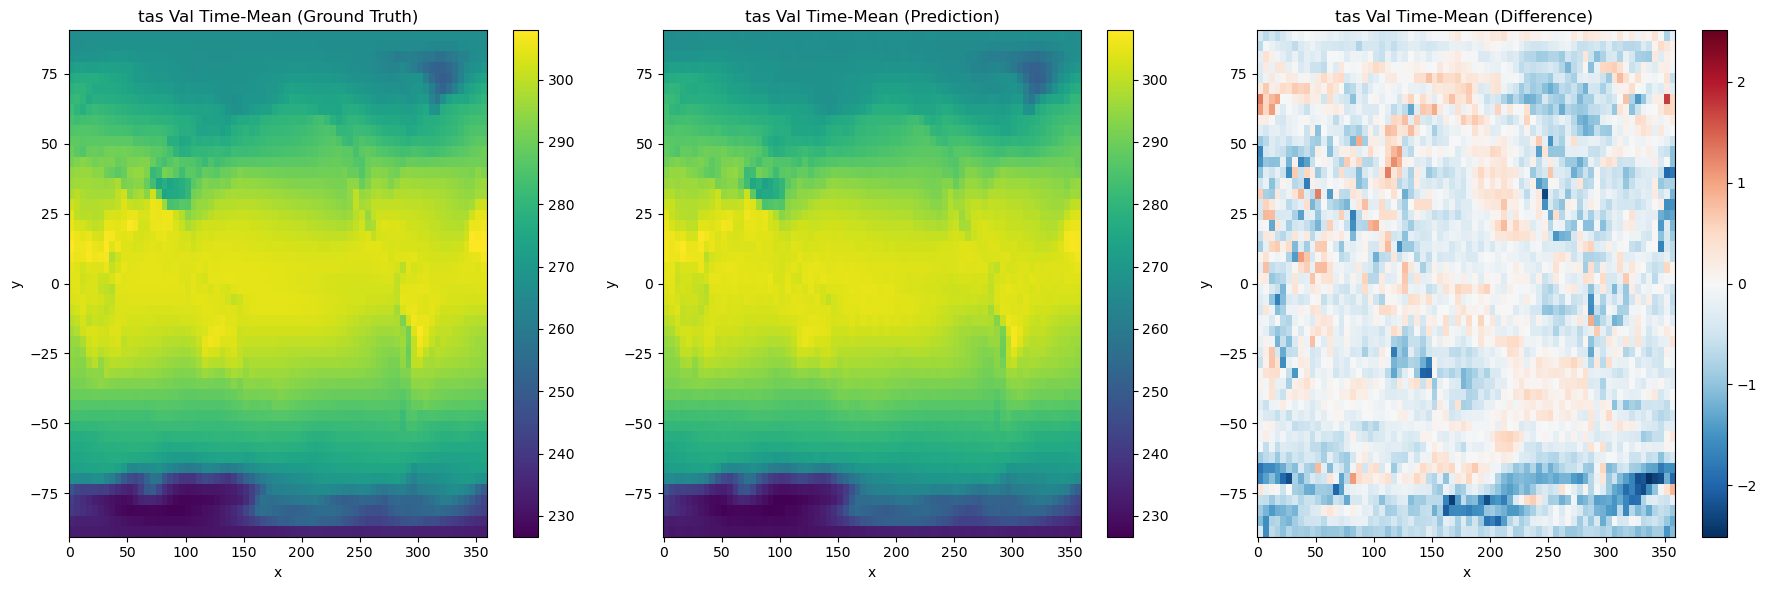

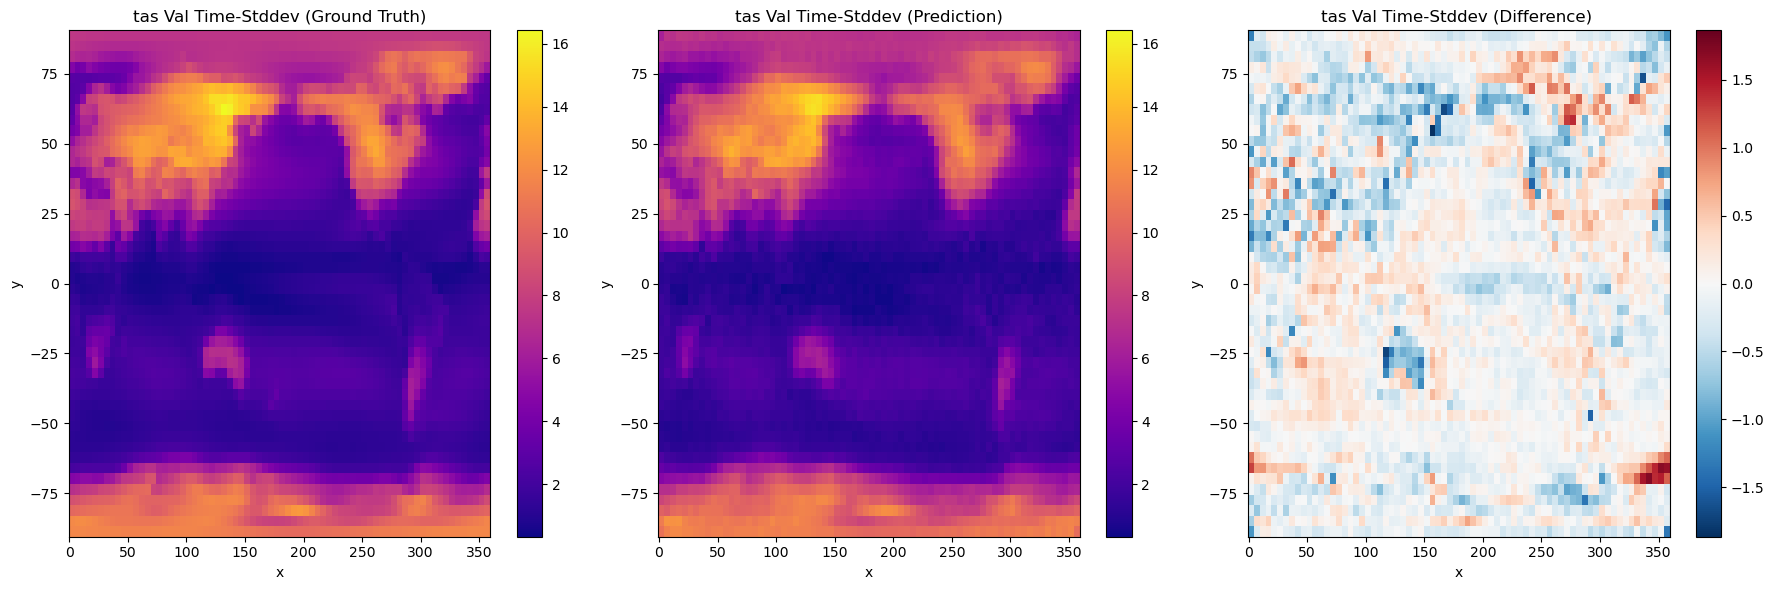

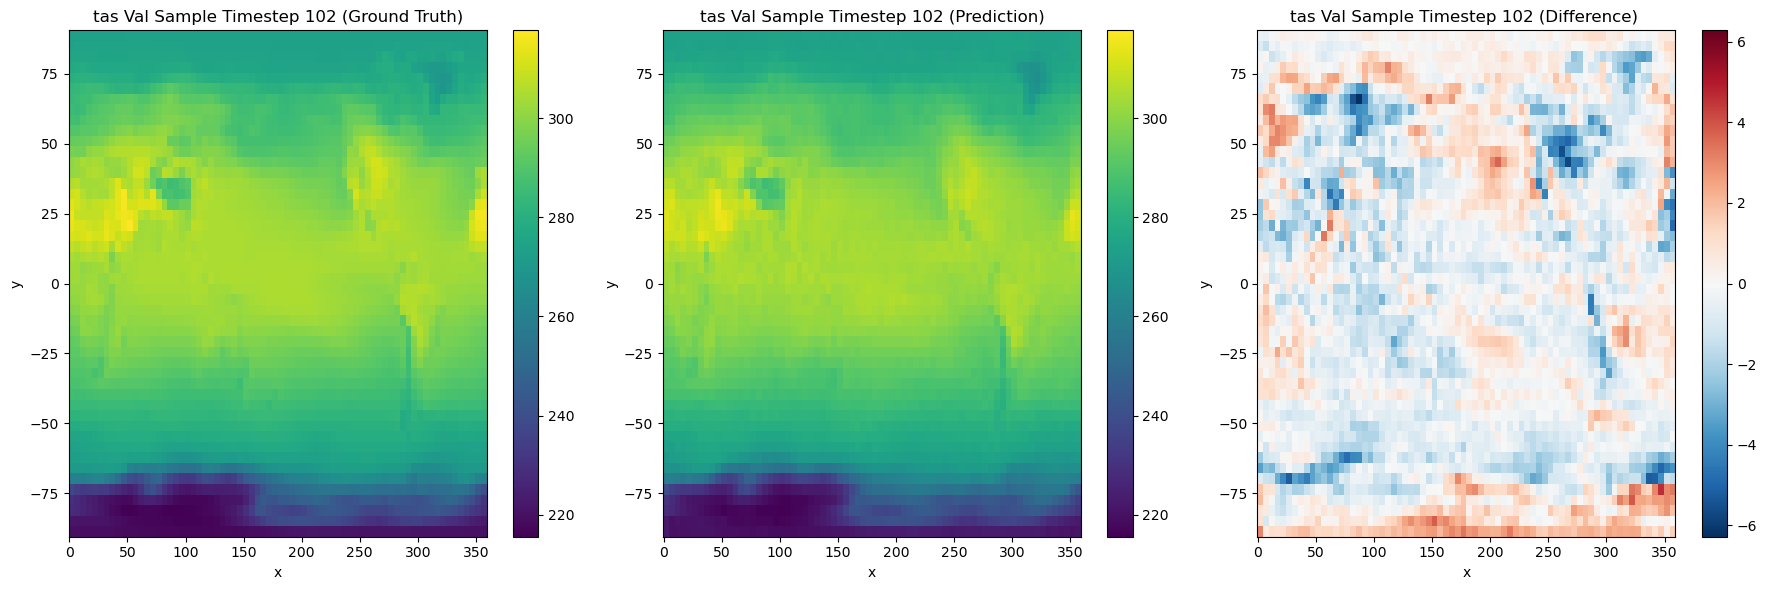

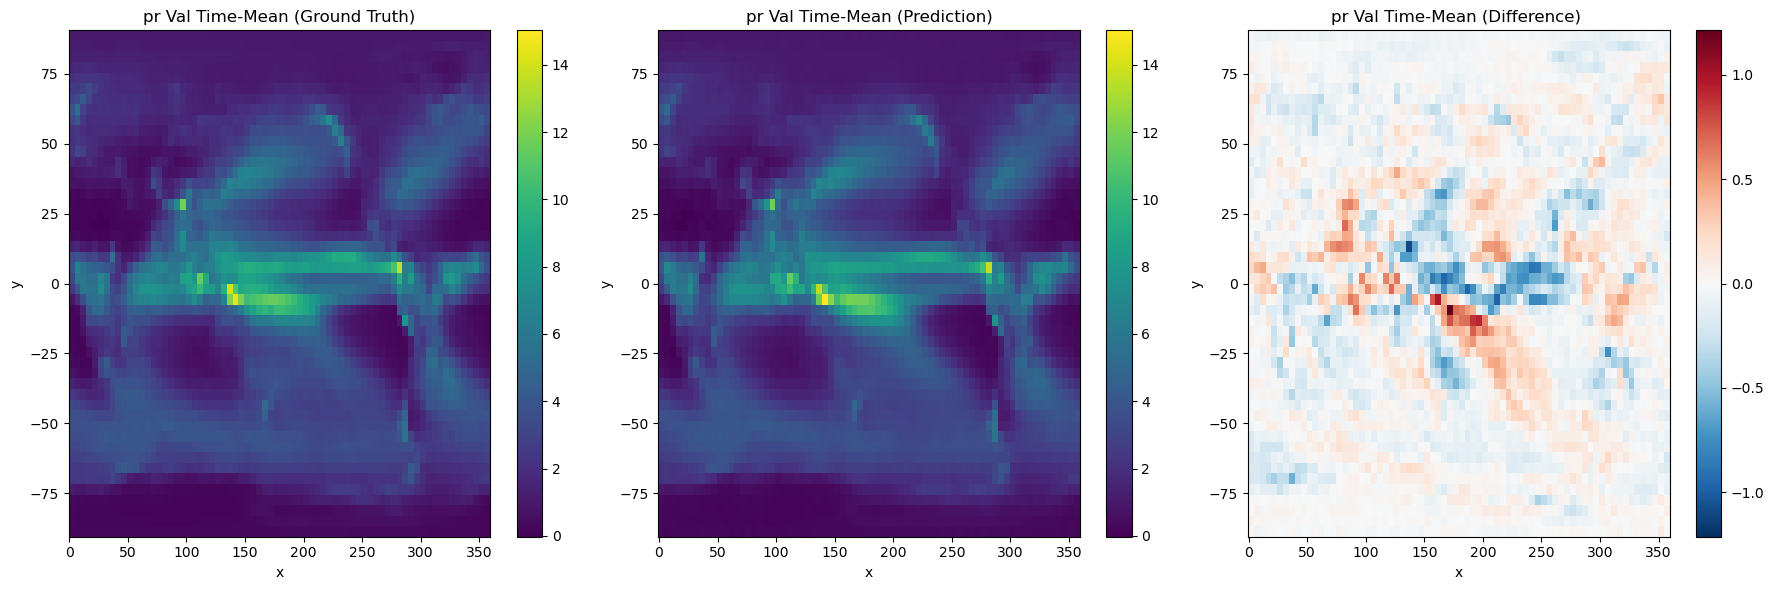

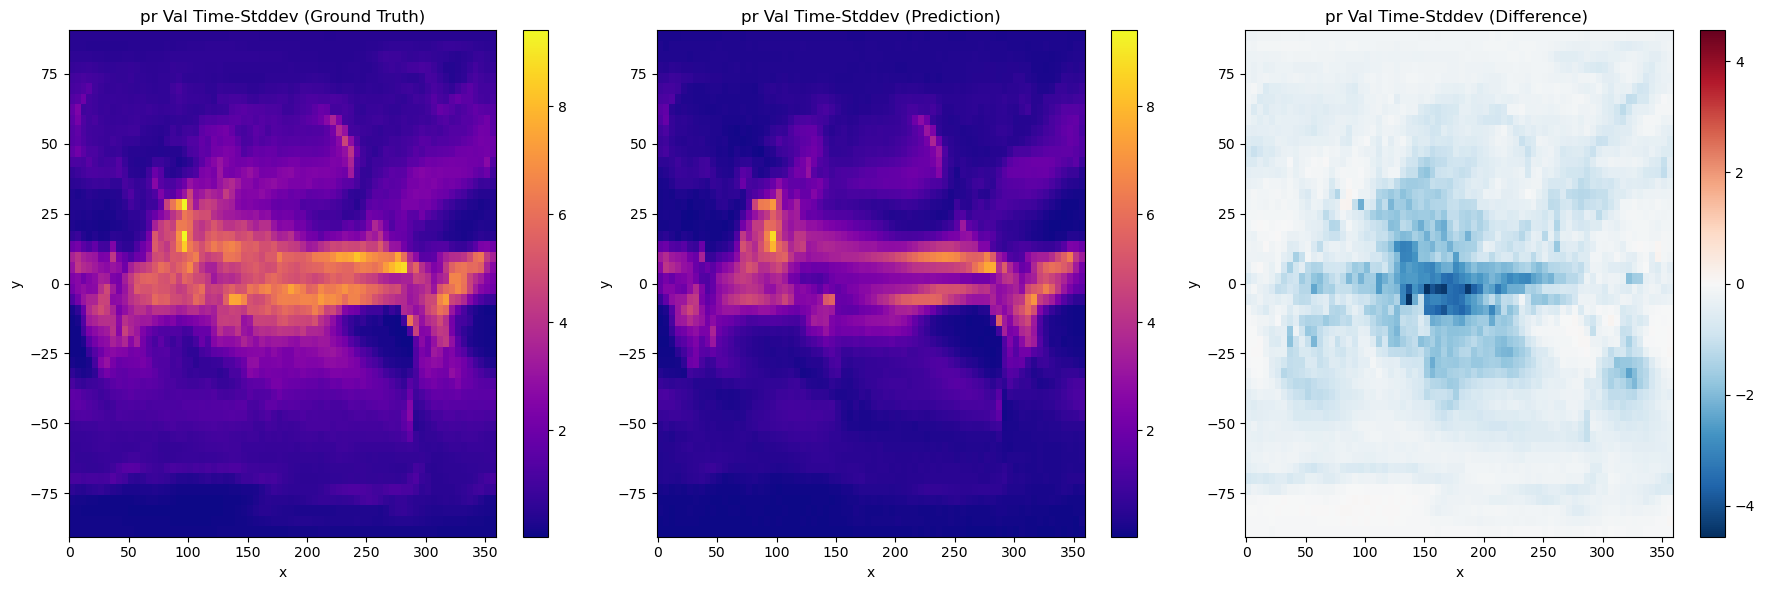

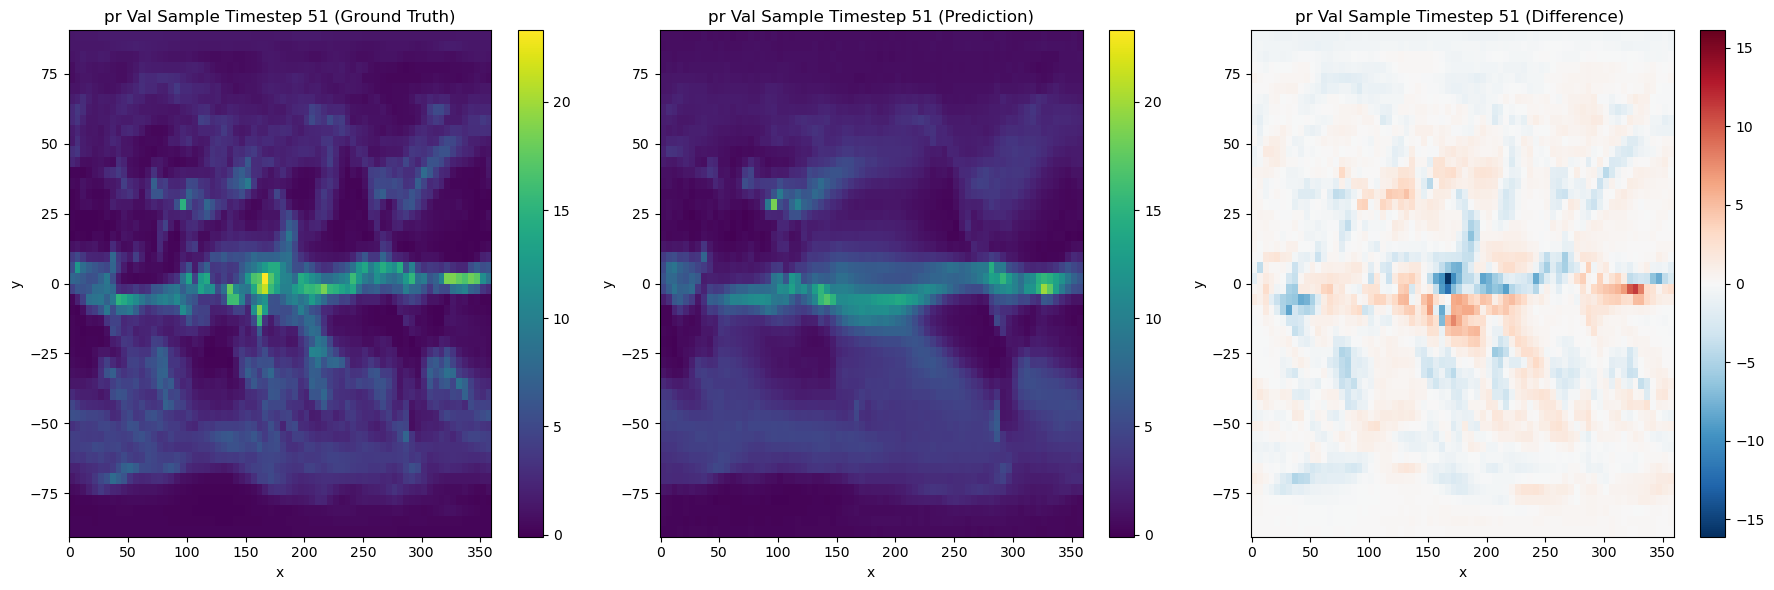

In [17]:
# Load validation predictions
# make sure to have run the validation loop at least once
val_preds = np.load("val_preds.npy")
val_trues = np.load("val_trues.npy")

lat, lon = datamodule.get_coords()
output_vars = datamodule.output_vars
time = np.arange(val_preds.shape[0])

for i, var in enumerate(output_vars):
    pred_xr = xr.DataArray(val_preds[:, i], dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})
    true_xr = xr.DataArray(val_trues[:, i], dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})

    # --- Time Mean ---
    plot_comparison(true_xr.mean("time"), pred_xr.mean("time"), f"{var} Val Time-Mean")

    # --- Time Stddev ---
    plot_comparison(true_xr.std("time"), pred_xr.std("time"), f"{var} Val Time-Stddev", cmap="plasma")

    # --- Random timestep ---
    t_idx = np.random.randint(0, len(time))
    plot_comparison(true_xr.isel(time=t_idx), pred_xr.isel(time=t_idx), f"{var} Val Sample Timestep {t_idx}")
